# Bayesian optimization

When a function is expensive to evaluate, or when gradients are not available, optimalizing it requires more sophisticated methods than gradient descent. One such method is Bayesian optimization, which lies close to active learning. In Bayesian optimization, instead of picking queries by maximizing the uncertainty of predictions, function values are evaluated at points where the promise of finding a better value is large. In modAL, these algorithms are implemented with the ```BayesianOptimizer``` class, which is a sibling of ```ActiveLearner```. In the following example, their use is demonstrated on a toy problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI

%matplotlib inline

## The function to be optimized

We are going to optimize a simple function to demonstrate the use of ```BayesianOptimizer```.

In [2]:
import numpy as np

# generating the data
X = np.linspace(0, 20, 1000).reshape(-1, 1)
y = np.sin(X)/2 - ((10 - X)**2)/50 + 2

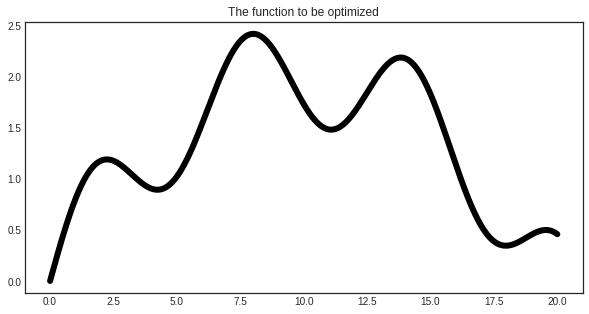

In [3]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X, y, c='k', linewidth=6)
    plt.title('The function to be optimized')
    plt.show()

## Gaussian processes
In Bayesian optimization, usually a Gaussian process regressor is used to predict the function to be optimized. One reason is that Gaussian processes can estimate the uncertainty of the prediction at a given point. This in turn can be used to estimate the possible gains at the unknown points.

In [4]:
# assembling initial training set
X_initial, y_initial = X[150].reshape(1, -1), y[150].reshape(1, -1)

# defining the kernel for the Gaussian process
kernel = Matern(length_scale=1.0)
regressor = GaussianProcessRegressor(kernel=kernel)

## Optimizing using *expected improvement*
During the optimization, the utility of each point is given by the so-called *acquisition function*. In this case, we are going to use the *expected improvement*, which is defined by
$$EI(x) = (\mu(x) - f(x^+)) \psi\Big( \frac{\mu(x) - f(x^+)}{\sigma(x)} \Big) + \sigma(x) \phi\Big( \frac{\mu(x) - f(x^+)}{\sigma(x)} \Big),$$
where $\mu(x)$ and $\sigma(x)$ are the mean and variance of the Gaussian process regressor at $x$, $f$ is the function to be optimized with estimated maximum at $x^+$, and $\psi(z)$, $\phi(z)$ denotes the cumulative distribution function and density function of a standard Gaussian distribution. After each query, the acquisition function is reevaluated and the new query is chosen to maximize the acquisition function. 

In [5]:
# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_initial, y_training=y_initial,
    query_strategy=max_EI
)

In [6]:
# Bayesian optimization
for n_query in range(5):
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

Using *expected improvement*, the first five queries are the following.

In [7]:
y_pred, y_std = optimizer.predict(X, return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()
X_max, y_max = optimizer.get_max()

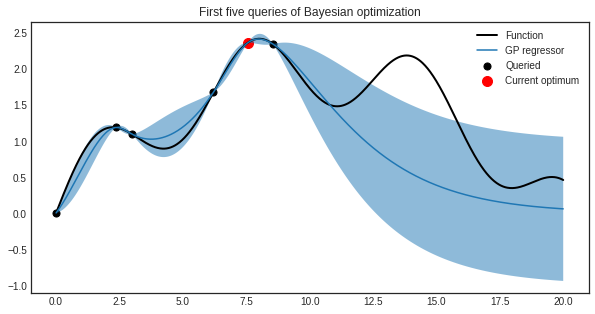

In [8]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(optimizer.X_training, optimizer.y_training, c='k', s=50, label='Queried')
    plt.scatter(X_max, y_max, s=100, c='r', label='Current optimum')
    plt.plot(X.ravel(), y, c='k', linewidth=2, label='Function')
    plt.plot(X.ravel(), y_pred, label='GP regressor')
    plt.fill_between(X.ravel(), y_pred - y_std, y_pred + y_std, alpha=0.5)
    plt.title('First five queries of Bayesian optimization')
    plt.legend()
    plt.show()

## Acquisition functions
Currently, there are three built in acquisition functions in the ```modAL.acquisition``` module: *expected improvement*, *probability of improvement* and *upper confidence bounds*. [You can find them in detail here](https://cosmic-cortex.github.io/modAL/Acquisition-functions).
